<a href="https://colab.research.google.com/github/mohameddhameem/IBM-Machine-Learning/blob/master/Deep%20Learning%20and%20Reinforcement%20Learning/Final%20Assignment/Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Human vs Horse

## Problem Definition

Company XYZ would like to build a Deep Learning model to classify horse vs human images. The images are of horses and humans, and the classification task is to predict whether the image is a horse or a human.
With pre-trained models like InceptionV3, the model can be trained to classify images.

In [11]:
# import required libraries
import os
import zipfile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Set collection

In [12]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 

--2022-05-16 03:22:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   147MB/s    in 1.0s    

2022-05-16 03:22:53 (147 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2022-05-16 03:22:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.250.101.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response

In [15]:
# all the required train and validation files are available in a zip file. Unzip the files for training and validation
local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [16]:
# Lets assign dedicated folder for training and validation
train_horses_dir = '/tmp/training/horses'
train_humans_dir = '/tmp/training/humans'
validation_horses_dir = '/tmp/validation/horses'
validation_humans_dir = '/tmp/validation/humans'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print('Total Horse Training files',len(train_horses_fnames))
print('Total Horse Training files',len(train_humans_fnames))
print('Total Horse Training files',len(validation_horses_fnames))
print('Total Horse Training files',len(validation_humans_fnames))

Total Horse Training files 500
Total Horse Training files 527
Total Horse Training files 128
Total Horse Training files 128


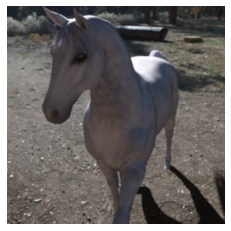

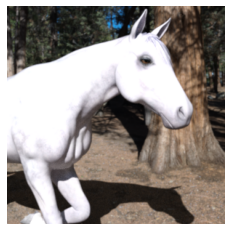

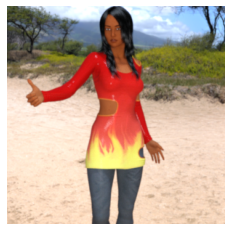

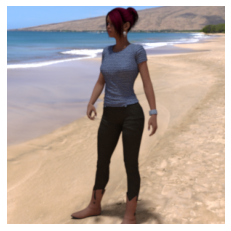

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_horse = [os.path.join(train_horses_dir, fname) 
                for fname in train_horses_fnames[pic_index-2:pic_index]]
next_human = [os.path.join(train_humans_dir, fname) 
                for fname in train_humans_fnames[pic_index-2:pic_index]]


for i, img_path in enumerate(next_horse+next_human):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()


In [18]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(# Your Code Here
                                  rescale = 1./255.,
                                  )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(# Your Code Here
                                                    train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150)
                                                    )     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( # Your Code Here
                                                         validation_dir,
                                                         batch_size = 20,
                                                         class_mode = 'binary',
                                                         target_size = (150, 150)
                                                         )

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Dataset Description

We have got 1027 images for training and 256 images for validation. 

Below is the highlevel break down for each these classes ( Horse vs Human )

* Total Horse Training files 500
* Total Horse Training files 527
* Total Horse Training files 128
* Total Horse Training files 128

## Model building

In [26]:
# Define a Callback class that stops training once accuracy reaches 99.9% We dont want to overfit our model.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

### Basic CNN for Image Classification

We will use a basic CNN first to explore the model building before we use Transfer learning

In [31]:
# Basic CNN Model building
cnn_model = tf.keras.models.Sequential([
# YOUR CODE HERE
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

cnn_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
BATCH_SIZE = 20
TRAIN_STEPS_PER_EPOCH = len(train_horses_fnames)//BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(validation_horses_fnames)//BATCH_SIZE
callbacks = myCallback()
history = cnn_model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = TRAIN_STEPS_PER_EPOCH * 2,
                    epochs = 100,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    verbose = 1,
                    callbacks=[callbacks]
                    )

### InceptionV3

In [19]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

87924736/87910968 [==============================] - 1s 0us/step


### Freeze top layers

In [20]:
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  # Your Code Here
  layer.trainable = False

In [21]:
# Print the model summary
# pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [22]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [27]:
# we will use Functional API to merge both pretrained model and our custom model
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 conv2d_17 (Conv2D)             (None, 16, 16, 96)   82944       ['activation_16[0][0]']          
                                                                                                  
 conv2d_18 (Conv2D)             (None, 16, 16, 64)   16384       ['average_pooling2d_1[0][0]']    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 16, 16, 64)  192         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 64)  192         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

## Model Training

In [28]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
BATCH_SIZE = 20
TRAIN_STEPS_PER_EPOCH = len(train_horses_fnames)//BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(validation_horses_fnames)//BATCH_SIZE
callbacks = myCallback()
history = model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = TRAIN_STEPS_PER_EPOCH * 2,
                    epochs = 100,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    verbose = 1,
                    callbacks=[callbacks]
                    )

Epoch 1/100
50/50 [==============================] - 69s 1s/step - loss: 0.1665 - accuracy: 0.9392 - val_loss: 0.0146 - val_accuracy: 0.9917
Epoch 2/100
50/50 [==============================] - 63s 1s/step - loss: 0.0330 - accuracy: 0.9899 - val_loss: 0.0167 - val_accuracy: 0.9917
Epoch 3/100
50/50 [==============================] - 63s 1s/step - loss: 0.0169 - accuracy: 0.9970 - val_loss: 0.0508 - val_accuracy: 0.9833
Epoch 4/100
50/50 [==============================] - 63s 1s/step - loss: 0.0139 - accuracy: 0.9939 - val_loss: 0.2000 - val_accuracy: 0.9500
Epoch 5/100
50/50 [==============================] - 64s 1s/step - loss: 0.0374 - accuracy: 0.9919 - val_loss: 0.1565 - val_accuracy: 0.9583
Epoch 6/100
50/50 [==============================] - 64s 1s/step - loss: 0.0140 - accuracy: 0.9940 - val_loss: 0.0087 - val_accuracy: 0.9917
Epoch 7/100
50/50 [==============================] - 65s 1s/step - loss: 0.0127 - accuracy: 0.9940 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 8/100
5

KeyboardInterrupt: ignored

### Model Accuracy

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()